In [1]:
import os
from unsloth import FastModel
import torch

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [2]:
fourbit_models = [
    # 4bit dynamic quants for superior accuracy and low memory use
    "unsloth/gemma-3-1b-it-unsloth-bnb-4bit",
    "unsloth/gemma-3-4b-it-unsloth-bnb-4bit",
    "unsloth/gemma-3-12b-it-unsloth-bnb-4bit",
    "unsloth/gemma-3-27b-it-unsloth-bnb-4bit",

    # Other popular models!
    "unsloth/Llama-3.1-8B",
    "unsloth/Llama-3.2-3B",
    "unsloth/Llama-3.3-70B",
    "unsloth/mistral-7b-instruct-v0.3",
    "unsloth/Phi-4",
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastModel.from_pretrained(
    model_name = "unsloth/gemma-3-4b-it",
    max_seq_length = 2048, # Choose any for long context!
    load_in_4bit = True,  # 4 bit quantization to reduce memory
    load_in_8bit = False, # [NEW!] A bit more accurate, uses 2x memory
    full_finetuning = False, # [NEW!] We have full finetuning now!
    # token = "hf_...", # use one if using gated models
)

==((====))==  Unsloth 2025.5.4: Fast Gemma3 patching. Transformers: 4.51.3.
   \\   /|    NVIDIA GeForce RTX 4080. Num GPUs = 1. Max memory: 15.694 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 8.9. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [3]:
model = FastModel.get_peft_model(
    model,
    finetune_vision_layers     = False, # Turn off for just text!
    finetune_language_layers   = True,  # Should leave on!
    finetune_attention_modules = True,  # Attention good for GRPO
    finetune_mlp_modules       = True,  # SHould leave on always!

    r = 8,           # Larger = higher accuracy, but might overfit
    lora_alpha = 8,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
)

Unsloth: Making `model.base_model.model.language_model.model` require gradients


In [4]:
from unsloth.chat_templates import get_chat_template
tokenizer = get_chat_template(
    tokenizer,
    chat_template = "gemma-3",
)

In [5]:
import sys
## Env variables and preparation stuffs
sys.path.insert(0, "../")
from src_code.data_utils.dataset import GridDataset
from src_code.data_utils.dataset_utils import dataset_generator

In [7]:
sys_role = "You are a helpful assistant working in path planning in a 2D grid."
dataset = GridDataset(grid_size=5, seed = 42, wall_symbol="#", free_symbol=".", cell_size=10)
ft_dataset = dataset_generator(dataset, sys_role, train_num=1000, val_num=2, test_num=2)

len(train_list)=1000
len(val_list)=2
len(test_list)=2


In [8]:
from unsloth.chat_templates import standardize_data_formats
ft_dataset = standardize_data_formats(ft_dataset['train'])

In [26]:
ft_dataset[0]

{'messages': [{'content': 'You are a helpful assistant working in path planning in a 2D grid.',
   'role': 'system'},
  {'content': "Here is the grid world:\n # # # # # # #\n # . . G . . #\n # . . . . # #\n # # # . . . #\n # . . # S # #\n # # . . . . #\n # # # # # # #\n\nThe S cell is the starting cell,\nthe G cell is the goal cell,\nthe # cells are obstacles,\nand the . cells are free cells.\n\nRules:\nThe grid size is 5x5\nThe path must not pass through the obstacles.\nYou can move up, down, left, or right from one cell to another.\nYou cannot move diagonally.\nThe path must be the shortest path from the starting cell to the goal cell.\nThe output should be a sequence of steps to reach the goal cell.\nOutput the steps only.\n\nActions:\nOnly give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'\ngo up: move one cell up\ngo down: move one cell down\ngo left: move one cell left\ngo right: move one cell right\nnot solvable: it is not possible to go the the 

In [10]:
def apply_chat_template(examples):
    texts = tokenizer.apply_chat_template(examples["messages"])
    return { "text" : texts }

ft_dataset = ft_dataset.map(apply_chat_template, batched = True)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [11]:
ft_dataset[0]['text']

"<bos><start_of_turn>user\nYou are a helpful assistant working in path planning in a 2D grid.\n\nHere is the grid world:\n # # # # # # #\n # . . G . . #\n # . . . . # #\n # # # . . . #\n # . . # S # #\n # # . . . . #\n # # # # # # #\n\nThe S cell is the starting cell,\nthe G cell is the goal cell,\nthe # cells are obstacles,\nand the . cells are free cells.\n\nRules:\nThe grid size is 5x5\nThe path must not pass through the obstacles.\nYou can move up, down, left, or right from one cell to another.\nYou cannot move diagonally.\nThe path must be the shortest path from the starting cell to the goal cell.\nThe output should be a sequence of steps to reach the goal cell.\nOutput the steps only.\n\nActions:\nOnly give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'\ngo up: move one cell up\ngo down: move one cell down\ngo left: move one cell left\ngo right: move one cell right\nnot solvable: it is not possible to go the the goal cell from the start cell\n\nOut

In [43]:
from trl import SFTTrainer, SFTConfig
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = ft_dataset,
    eval_dataset = None, # Can set up evaluation!
    args = SFTConfig(
        dataset_text_field = "text",
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4, # Use GA to mimic batch size!
        warmup_steps = 5,
        num_train_epochs = 100, # Set this for 1 full training run.
        max_steps = 30,
        learning_rate = 2e-4, # Reduce to 2e-5 for long training runs
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        report_to = "none", # Use this for WandB etc
    ),
)

Unsloth: Tokenizing ["text"] (num_proc=24):   0%|          | 0/1000 [00:00<?, ? examples/s]

In [44]:
from unsloth.chat_templates import train_on_responses_only
trainer = train_on_responses_only(
    trainer,
    instruction_part = "<start_of_turn>user\n",
    response_part = "<start_of_turn>model\n",
)

Map (num_proc=24):   0%|          | 0/1000 [00:00<?, ? examples/s]

In [45]:
tokenizer.decode(trainer.train_dataset[0]["input_ids"])

"<bos><bos><start_of_turn>user\nYou are a helpful assistant working in path planning in a 2D grid.\n\nHere is the grid world:\n # # # # # # #\n # . . G . . #\n # . . . . # #\n # # # . . . #\n # . . # S # #\n # # . . . . #\n # # # # # # #\n\nThe S cell is the starting cell,\nthe G cell is the goal cell,\nthe # cells are obstacles,\nand the . cells are free cells.\n\nRules:\nThe grid size is 5x5\nThe path must not pass through the obstacles.\nYou can move up, down, left, or right from one cell to another.\nYou cannot move diagonally.\nThe path must be the shortest path from the starting cell to the goal cell.\nThe output should be a sequence of steps to reach the goal cell.\nOutput the steps only.\n\nActions:\nOnly give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'\ngo up: move one cell up\ngo down: move one cell down\ngo left: move one cell left\ngo right: move one cell right\nnot solvable: it is not possible to go the the goal cell from the start cell\n

In [46]:
tokenizer.decode([tokenizer.pad_token_id if x == -100 else x for x in trainer.train_dataset[0]["labels"]]).replace(tokenizer.pad_token, " ")

"                                                                                                                                                                                                                                                                                                                                              ('go up', 'go up', 'go up', 'go left')<end_of_turn>\n"

In [47]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,000 | Num Epochs = 1 | Total steps = 30
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 14,901,248/4,000,000,000 (0.37% trained)


Step,Training Loss
1,0.313600
2,0.308300
3,0.298000
4,0.397000
5,0.375000
6,0.423500
7,0.314300
8,0.365300
9,0.309000
10,0.420400


In [48]:
from src_code.data_utils.prompt_utils import prompt_generator
dataset = GridDataset(grid_size=5, seed = 42, wall_symbol="#", free_symbol=".")
img, grid_world = dataset[0]
prompt_img = prompt_generator(grid_world, pure_language=False, img=None, img_symbol="This image")
print(prompt_img)

Here is the grid world:
 # # # # # # #
 # . . G . . #
 # . . . . # #
 # # # . . . #
 # . . # S # #
 # # . . . . #
 # # # # # # #

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the . cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starti

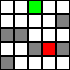

In [49]:
img

In [50]:
str(grid_world.a_star())

"('go up', 'go up', 'go up', 'go left')"

In [51]:
model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Gemma3ForConditionalGeneration(
      (vision_tower): SiglipVisionModel(
        (vision_model): SiglipVisionTransformer(
          (embeddings): SiglipVisionEmbeddings(
            (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
            (position_embedding): Embedding(4096, 1152)
          )
          (encoder): SiglipEncoder(
            (layers): ModuleList(
              (0-26): 27 x SiglipEncoderLayer(
                (layer_norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
                (self_attn): SiglipAttention(
                  (k_proj): Linear(in_features=1152, out_features=1152, bias=True)
                  (v_proj): Linear(in_features=1152, out_features=1152, bias=True)
                  (q_proj): Linear(in_features=1152, out_features=1152, bias=True)
                  (out_proj): Linear(in_features=1152, out_features=1152, bias=True)
                

In [52]:
from unsloth.chat_templates import get_chat_template
tokenizer = get_chat_template(
    tokenizer,
    chat_template = "gemma-3",
)
messages = [{
    "role": "user",
    "content": [{
        "type" : "text",
        "text" : prompt_img,
    }]
}]
text = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt = True, # Must add for generation
)
outputs = model.generate(
    **tokenizer([text], return_tensors = "pt").to("cuda"),
    max_new_tokens = 64, # Increase for longer outputs!
    # Recommended Gemma-3 settings!
    temperature = 1.0, top_p = 0.95, top_k = 64,
)
tokenizer.batch_decode(outputs)

["<bos><start_of_turn>user\nHere is the grid world:\n # # # # # # #\n # . . G . . #\n # . . . . # #\n # # # . . . #\n # . . # S # #\n # # . . . . #\n # # # # # # #\n\nThe S cell is the starting cell,\nthe G cell is the goal cell,\nthe # cells are obstacles,\nand the . cells are free cells.\n\nRules:\nThe grid size is 5x5\nThe path must not pass through the obstacles.\nYou can move up, down, left, or right from one cell to another.\nYou cannot move diagonally.\nThe path must be the shortest path from the starting cell to the goal cell.\nThe output should be a sequence of steps to reach the goal cell.\nOutput the steps only.\n\nActions:\nOnly give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'\ngo up: move one cell up\ngo down: move one cell down\ngo left: move one cell left\ngo right: move one cell right\nnot solvable: it is not possible to go the the goal cell from the start cell\n\nOutput example:\n('go up', 'go right', 'go right', 'go down', 'go right'